In [1]:
import pandas as pd
from datetime import datetime, date
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from pandas_profiling import ProfileReport

from lightgbm import LGBMRegressor
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV

pd.options.display.max_rows = 40
pd.options.display.max_columns = None

In [2]:
def generate_installment_dates(row):
    periodicity = row.Periodicity
    deltas_periodicity = {
        "Biweekly": relativedelta(weeks=2),
        "Weekly": relativedelta(weeks=2),
        "Monthly": relativedelta(months=1)
    }
    if periodicity not in deltas_periodicity:
        return []
    
    delta_periodicity = deltas_periodicity[periodicity]
    
    orig_date = row.OriginationDate
    terms = row.Term
    
    dates = []
    curr = orig_date
    for _ in range(terms):
        curr += delta_periodicity
        dates.append(curr.date())
    
    return dates

# Load and analyze data

## Agency product name
>  Información sobre agencia que agrupa créditos, el tipo de crédito (PDL o BGL, payday loans o business growth loans, respectivamente).

```
AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Country (Categórica): País de la operación.
```

In [3]:
df_agency = pd.read_csv("loan_agency_product_name.csv")
profile = ProfileReport(df_agency, title="Agency product name", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Funding Origination

> Información sobre a qué agencia pertenece cada crédito y la fecha de creación de cada crédito.

```
- LoanId (Entero): ID único del crédito.

- AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

- FundingID (Entero): ID de la entidad financiadora.

- OriginationDate (Datetime): Fecha de originación del crédito.

- InstallmentAmount (Decimal): Valor del préstamo (valor de la cuota correspondiente = InstallmentAmount/Term).

- Periodicity (Categórica): Periodicidad del crédito.

- LoanOperationalStatus (Categórica): Estado operacional del crédito al fin del período (diciembre 2020).

- VAT (Entero): Porcentaje asignado al IVA.

- Term (Entero): Cantidad de plazos del crédito.
```

In [4]:
df_orig = pd.read_csv("loan_funding_origination_info.csv", parse_dates=["OriginationDate"])
df_orig.rename(inplace=True, columns={"InstallmentAmount":"LoanAmount"})
df_orig["InstallmentAmount"] = df_orig.LoanAmount / df_orig.Term

profile = ProfileReport(df_orig, title="Funding Origination", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/nox/repos/venv/lib64/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

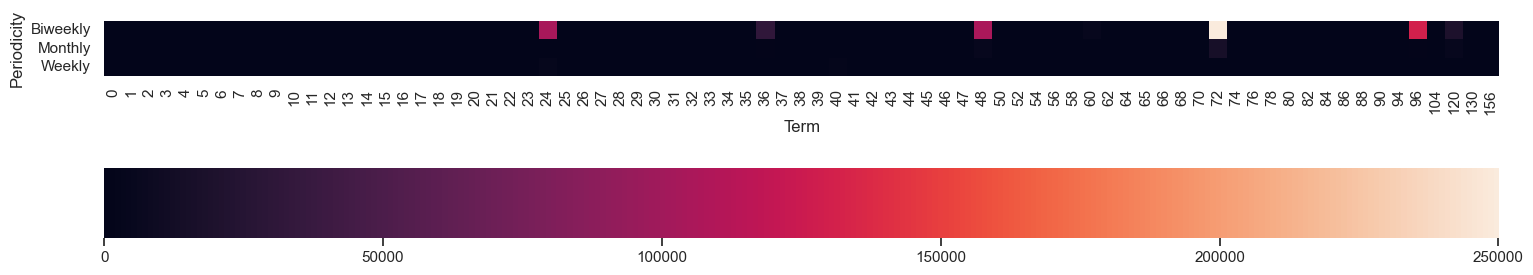

In [5]:
plt.figure(figsize=(18,8))
sns.heatmap(
    df_orig.pivot_table(index="Periodicity", columns="Term", values="LoanId", aggfunc="count", fill_value=0),
    square=True,
    cbar_kws={"orientation":"horizontal"},
)
plt.show()

## Payments
> Incluye pagos y dinámica histórica (desde 2019) de las operaciones de Hopp. La creación de créditos fue removida desde 2019 en adelante. Datos hasta junio 2020 inclusive.

```
LoanId (Entero): ID único del crédito.

PaymentId (Entero): ID único de cada pago.

PaymentSource (Categórica): Fuente de Pago (regular, contractor, alternative, additional).

PaymentType (Entero): Variable que clasifica distintos mecanismos de pago adicional.

PaymentTypeDescription (Categórica): Descripción de los mecanismos de pago adicional.

PaymentAmount (Decimal): Total pagado en el pago con PaymentId de la fila.

PaymentPrincipalAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de principal.

PaymentInterestAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de interés.

PaymentVATAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de IVA.

PaymentDueDate (Datetime): Fecha de aplicación del pago procesado (no disponible para todas las PaymentSources).

PaymentTransferDate (Datetime): Fecha en que Hopp recibió la transferencia bancaria del pago indicado (no disponible para todas las PaymentSources).

PaymentProcessingDate (Datetime): Fecha en que Hopp procesó el pago indicado (disponible para todas las PaymentSources).
```

In [6]:
df_payments = pd.read_csv("loan_payments_dataset.csv", parse_dates=["PaymentProcessingDate", "PaymentTransferDate", "PaymentDueDate"])

profile = ProfileReport(df_payments, title="Payments", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [90]:
df_payments.groupby(["LoanId", "PaymentProcessingDate", "PaymentSource"]).PaymentPrincipal.count().sort_values(ascending=False).head(20)

LoanId   PaymentProcessingDate  PaymentSource
530395   2019-10-24             Regular          67
554153   2019-11-08             Regular          66
566271   2019-11-08             Regular          66
9011205  2019-03-15             Regular          65
555414   2019-10-24             Regular          65
562835   2019-11-08             Regular          65
567895   2019-10-24             Regular          64
9126402  2019-10-09             Regular          64
567692   2019-10-24             Regular          64
9138385  2019-10-09             Regular          64
536373   2019-11-08             Regular          64
535502   2019-11-08             Regular          64
563847   2019-10-24             Regular          63
560668   2019-10-24             Regular          63
567420   2019-10-24             Regular          62
534748   2019-11-08             Regular          61
536051   2019-11-08             Regular          61
527352   2019-10-24             Regular          60
527501   2019-11-1

In [91]:
df_payments = df_payments.sort_values(["LoanId", "PaymentProcessingDate", "PaymentSource"]).groupby(["LoanId", "PaymentProcessingDate", "PaymentSource"]).agg(
    {
        "PaymentTypeDescription": pd.Series.mode,
        "PaymentAmount": "sum",
        "PaymentPrincipal": "sum",
        "PaymentInterest": "sum",
        "PaymentVAT": pd.Series.mode,
        "PaymentDueDate": "min",
        "PaymentTransferDate": "min",
    }
).reset_index()

<AxesSubplot:title={'center':'Difference between processing date and transfer date'}, xlabel='days', ylabel='count'>

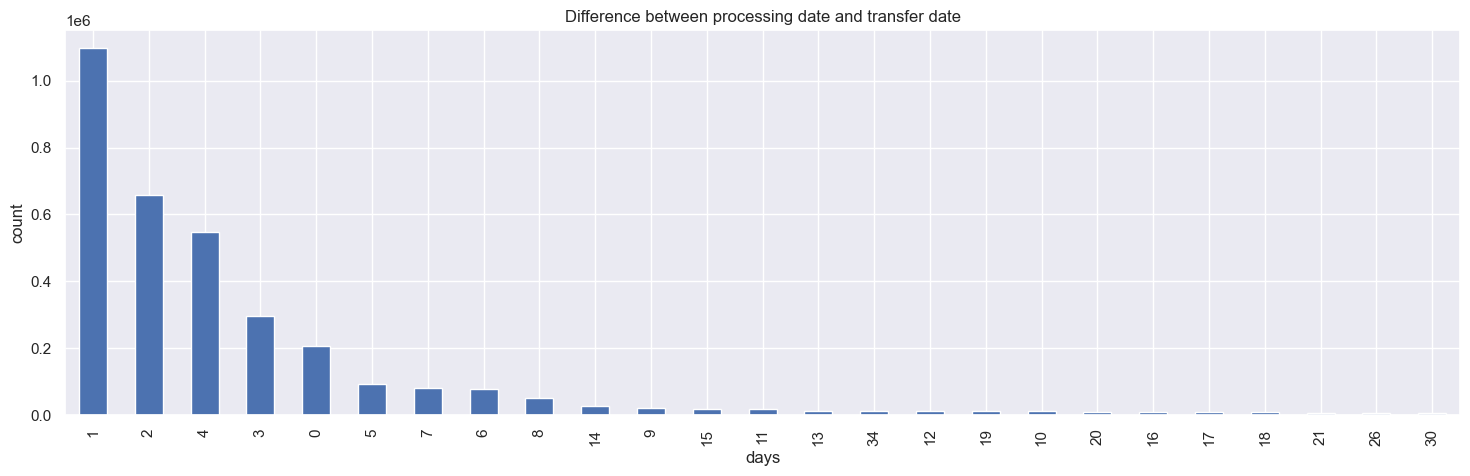

In [93]:
(df_payments.PaymentProcessingDate - df_payments.PaymentTransferDate).dt.days.value_counts().head(25).plot(
    kind="bar", title="Difference between processing date and transfer date",
    figsize=(18,5), xlabel="days", ylabel="count"
)

<AxesSubplot:title={'center':'Difference between payment due date and payment transfer date'}, xlabel='days', ylabel='count'>

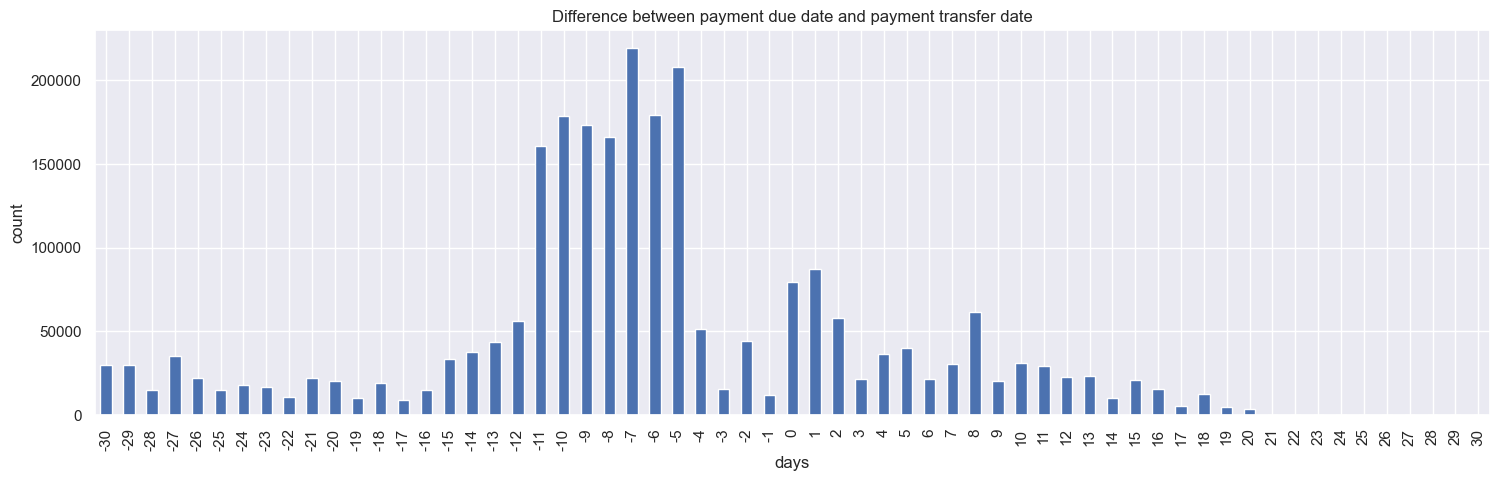

In [94]:
x = (df_payments[df_payments.PaymentDueDate.notna()].PaymentDueDate - df_payments[df_payments.PaymentDueDate.notna()].PaymentTransferDate).dt.days
x = x[x.between(-30, 30)].value_counts().sort_index()
x.plot(
    kind="bar", title="Difference between payment due date and payment transfer date", figsize=(18,5), xlabel="days", ylabel="count"
)

In [95]:
df_payments["DiffProcessingDateDueDate"] = (df_payments["PaymentProcessingDate"] - df_payments["PaymentDueDate"]).dt.days

/home/nox/repos/venv/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


<AxesSubplot:xlabel='DiffProcessingDateDueDate', ylabel='Density'>

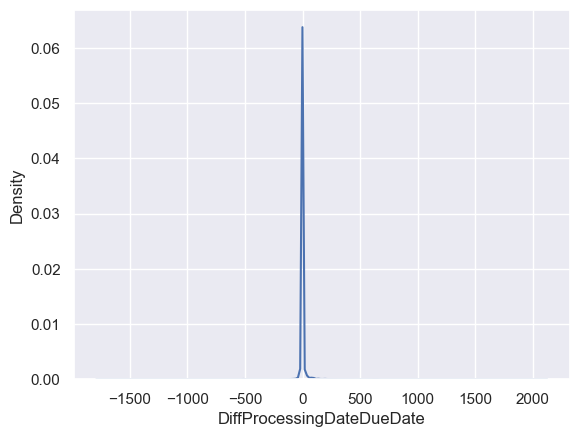

In [96]:
mean_diffdates = df_payments[df_payments.PaymentSource == "Regular"].sort_values("PaymentProcessingDate").groupby("LoanId").DiffProcessingDateDueDate.apply(np.diff).apply(np.mean)
sns.kdeplot(mean_diffdates)

In [97]:
mean_diffdates[mean_diffdates.between(-1,1)]

LoanId
3600      -0.133333
3846      -0.680000
3880      -0.680000
3881      -0.680000
3900      -0.680000
             ...   
9417746    0.823529
9417747    0.000000
9417748   -0.565217
9417749    0.000000
9417757    0.062500
Name: DiffProcessingDateDueDate, Length: 94452, dtype: float64

In [98]:
df_payments[df_payments.PaymentPrincipal > 0].LoanId.value_counts().head()

9176719    47
9182144    47
9372928    47
9405682    47
9344259    47
Name: LoanId, dtype: int64

<AxesSubplot:>

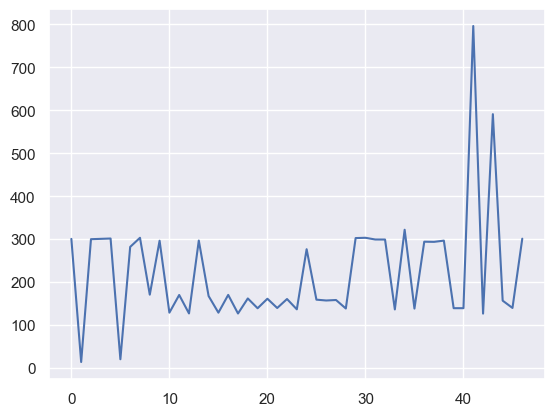

In [99]:
df_payments[(df_payments.PaymentPrincipal > 0) & (df_payments.LoanId == 9344259)].sort_values("PaymentProcessingDate").PaymentPrincipal.reset_index(drop=True).plot()

In [100]:
len(df_payments)

3377988

In [101]:
%%time
from sklearn.linear_model import LinearRegression, Ridge
from functools import lru_cache

i = 0

def fit_lr(arr):
    global i
    i += 1
    if (i % 100_000) == 0:
        print(i)
    lr = Ridge()
    x = np.arange(0, len(arr)).reshape(-1, 1)
    y = arr
    lr.fit(x, y)
    return (lr.intercept_, *list(lr.coef_))

def fit_lr_i(arr):
    i, c = fit_lr(arr)
    return i

def fit_lr_c(arr):
    i, c = fit_lr(arr)
    return c

#aggs = df_payments[
#        (df_payments.PaymentPrincipal > 0)
#    ].sort_values(
#        ["LoanId", "PaymentProcessingDate"]
#    ).groupby("LoanId").expanding().PaymentPrincipal.agg([fit_lr_i, fit_lr_c])

CPU times: user 19 µs, sys: 1e+03 ns, total: 20 µs
Wall time: 24.3 µs


In [102]:
#coefs = pd.DataFrame(
#    {"": df_payments[
#        (df_payments.PaymentPrincipal > 0)
#    ].sort_values(
#        ["LoanId", "PaymentProcessingDate"]
#    ).groupby("LoanId").expanding().PaymentPrincipal.agg(fit_lr_i)
#).rename(columns={"PaymentPrincipal": "RidgeCoefs"})

#coefs = pd.DataFrame.from_records(
#    coefs.RidgeCoefs.reset_index(drop=True),
#    index=coefs.index,
#    columns=["ridge_intercept", *[f"ridge_coef_{i}" for i in range(len(coefs.iloc[0].RidgeCoefs) - 1)]]
#)

In [103]:
#coefs.head()

In [104]:
# df_payments[(df_payments.PaymentPrincipal > 0) & (df_payments.LoanId == 9417754)]#.PaymentPrincipal.plot()

In [105]:
# df_orig[df_orig.LoanId == 9417754]

## Indexed dataset
> Información de tipo de indexación de cada crédito en el portafolio.

```
LoanId (Entero): ID único del crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Type (Categórica): Variable que indica si el crédito está indexado (Base, D-Indexed).

D-IndexedTo (Categórica): Variable que indica a quién indexa el crédito (Hopp, Zoltan, Ringu, Freeman).
```

In [20]:
df_dindex = pd.read_csv("loan_dindexedto_dataset.csv")

profile = ProfileReport(df_dindex, title="Indexed to", minimal=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Predictions sample
> Template con los préstamos y fechas a predecir.

In [21]:
predictions_sample = pd.read_csv("loan_payments_dataset_scoring.csv", names=["PaymentCode", "PaymentPrincipal"], dtype={
    "PaymentCode": str,
    "PaymentPrincipal": float
})

predictions_sample = predictions_sample.join(predictions_sample.PaymentCode.astype(str).str.extract(r'^(?P<PaymentSource>\d{2})(?P<Date>\d{6})(?P<LoanId>.*)'))

predictions_sample.LoanId = predictions_sample.LoanId.astype(int)
predictions_sample.PaymentSource = predictions_sample.PaymentSource.astype(int)
# predictions_sample.PaymentTypeId = predictions_sample.PaymentTypeId.astype(int)

predictions_sample.Date = pd.to_datetime(predictions_sample.Date, format="%y%m%d").dt.date

predictions_sample["PaymentType"] = predictions_sample.PaymentSource.apply(lambda x: x if x not in (0,1,2) else None)

predictions_sample.PaymentSource = predictions_sample.PaymentSource.map({
    0: "Regular",
    1: "Alternative",
    2: "Contractor"
}).fillna("Alternative")

In [22]:
predictions_sample.head()

PaymentCode  PaymentPrincipal PaymentSource        Date   LoanId  \
0  022102049402357               NaN    Contractor  2021-02-04  9402357   
1   00201030668519               NaN       Regular  2020-10-30   668519   
2  002011249339435               NaN       Regular  2020-11-24  9339435   
3  002104209148631               NaN       Regular  2021-04-20  9148631   
4   00210607131505               NaN       Regular  2021-06-07   131505   

   PaymentType  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [23]:
orig_loanids = set(df_orig.LoanId.unique())
predictions_loanids = set(predictions_sample.LoanId.unique())
print(f"All predictions in payments? {(orig_loanids & predictions_loanids) == predictions_loanids}. Diff: {len(predictions_loanids - orig_loanids)}")

All predictions in payments? False. Diff: 5


In [24]:
predictions_sample[~predictions_sample.LoanId.isin(df_orig.LoanId)]

PaymentCode  PaymentPrincipal PaymentSource        Date  LoanId  \
7928     002110295405               NaN       Regular  2021-10-29    5405   
50127    002112285406               NaN       Regular  2021-12-28    5406   
944338   002110225404               NaN       Regular  2021-10-22    5404   
1109375  002112305409               NaN       Regular  2021-12-30    5409   
1116352  002107205403               NaN       Regular  2021-07-20    5403   
1220610  002107235403               NaN       Regular  2021-07-23    5403   

         PaymentType  
7928             NaN  
50127            NaN  
944338           NaN  
1109375          NaN  
1116352          NaN  
1220610          NaN

In [25]:
cheats = {
"002107235403":1474,
"002107205403":1474,
"002110225404":591,
"002110295405":488,
"002112285406":1247,
"002112305409":1253
}

In [26]:
loan_ids_to_predict = predictions_sample.LoanId.unique()

<AxesSubplot:>

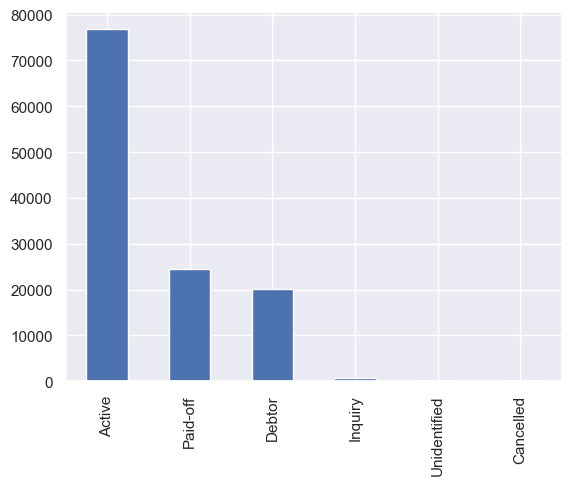

In [27]:
df_orig[df_orig.LoanId.isin(loan_ids_to_predict)].LoanOperationalStatus.value_counts().plot(kind="bar")

In [28]:
predictions_sample.LoanId.value_counts()

653139     64
9361293    64
9275791    59
9343898    59
9359087    59
           ..
9143458     1
9145866     1
519749      1
9279168     1
9153809     1
Name: LoanId, Length: 122351, dtype: int64

# Cross reference payments and origin

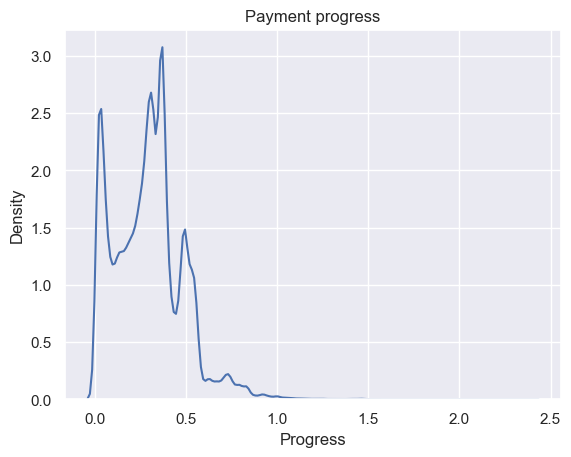

In [29]:
df = df_orig.merge(
    df_payments.LoanId.value_counts().rename("PaymentsRegistered"),
    left_on="LoanId",
    right_index=True
)
df["Progress"] = df.PaymentsRegistered / df.Term
sns.kdeplot(df[np.isfinite(df.Progress)].Progress)
plt.title("Payment progress")
plt.show()

# Do we need to predict for wanky loans?

In [106]:
predictions_sample.LoanId.isin(
    df_orig[df_orig.Term == 0].LoanId
).nunique()

2

# Orient data

In [108]:
df = pd.merge(df_payments, df_orig, left_on="LoanId", right_on="LoanId", how="left").sort_values(["PaymentProcessingDate", "LoanId"]) # , "PaymentId"

df = df.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

nzpayments = df[df.PaymentPrincipal != 0][["LoanId", "PaymentPrincipal", "PaymentProcessingDate"]].rename(
    columns={"PaymentProcessingDate":"LastNonZeroPaymentProcessingDate", "PaymentPrincipal": "LastNonZeroPaymentPrincipal"}
)
df = pd.merge_asof(df, nzpayments, left_on="PaymentProcessingDate", right_on="LastNonZeroPaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False)

ppa = df_payments[(df_payments.PaymentPrincipal > 0)].groupby("LoanId").PaymentPrincipal.agg(["mean", "median"]).rename(
    columns={"mean":"PaymentPrincipalMean", "median":"PaymentPrincipalMedian"}
)
df = df.merge(ppa, on="LoanId", how="left")

#df = df.join(aggs.droplevel("LoanId"))
#df.rename(
#    columns={"fit_lr_i": "ridge_intercept", "fit_lr_c": "ridge_coef_0"},
#    inplace=True
#)

# df = df.merge(coefs, on="LoanId", how="left")
# df["ridge_coef_0"] = r_coefs
# df["ridge_intercept"] = r_intercepts

df["DaysSincePreviousNonZeroPayment"] = (df.PaymentProcessingDate - df.LastNonZeroPaymentProcessingDate).dt.days

df["WasLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 15
df["WasReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 30
df["WasReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 90
df["WasReallyReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 180

df["WasEverLate"] = df.groupby("LoanId").WasLate.cumsum()# > 0
df["WasEverReallyLate"] = df.groupby("LoanId").WasReallyLate.cumsum()# > 0
df["WasEverReallyReallyLate"] = df.groupby("LoanId").WasReallyReallyLate.cumsum()# > 0
df["WasEverReallyReallyReallyLate"] = df.groupby("LoanId").WasReallyReallyReallyLate.cumsum()# > 0

df["AccumulatedPrincipals"] = df.groupby("LoanId").PaymentPrincipal.cumsum()
df["PrincipalPaidOff"] = df.AccumulatedPrincipals >= df.LoanAmount
df["PrincipalPaidOffProportion"] = df.AccumulatedPrincipals / df.LoanAmount



In [109]:
df["InstallmentProportion"] = df.PaymentPrincipal / df.InstallmentAmount

df = pd.merge_asof(df, df[["LoanId", "PaymentProcessingDate", "InstallmentProportion"]].rename(columns={"InstallmentProportion":"LastInstallmentProportion"}),
    left_on="PaymentProcessingDate", right_on="PaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False
)

df["MonthsSinceOrigination"] = (df.PaymentProcessingDate - df.OriginationDate).dt.days / 30

In [111]:
categories = ["PaymentSource", "AgencyId", "FundingID", "Periodicity", "LoanOperationalStatus", "VAT", "Term", "ProductName", "Type", "D-IndexedTo",] #"LoanId"] , "PaymentType"
for category in categories:
    df[category] = df[category].astype("category")

In [124]:
train_columns = [
    #"LoanId",
    'PaymentSource',
    #'PaymentType',
    'AgencyId',
    'FundingID',
    'LoanAmount',
    'Periodicity',
    'VAT',
    'Term',
    'InstallmentAmount',
    'ProductName',
    'Type',
    'D-IndexedTo',
    'PaymentPrincipalMean',
    'PaymentPrincipalMedian',
    'LastNonZeroPaymentPrincipal',
    'DaysSincePreviousNonZeroPayment',
    'WasEverLate',
    'WasEverReallyLate',
    'WasEverReallyReallyLate',
    'WasEverReallyReallyReallyLate',
    'LastInstallmentProportion',
    'AccumulatedPrincipals',
    "PrincipalPaidOffProportion",
    'PrincipalPaidOff',
    #"ridge_intercept",
    #"ridge_coef_0",
    "MonthsSinceOrigination"
]

In [125]:
train_df = df[(df.PaymentAmount >= 0) & (df.LoanAmount > 0) & (df.PaymentPrincipal >= 0)]

In [126]:
loans = train_df.LoanId.value_counts()
loans = loans[loans > 0]
len(loans)

190013

In [127]:
train_df = train_df[train_df.LoanId.isin(loans.index)]

In [128]:
train_df = train_df.sort_values(["LoanId", "PaymentProcessingDate"])
groups = LabelEncoder().fit_transform(train_df.LoanId)

In [129]:
y = train_df.PaymentPrincipal # InstallmentProportion
X = train_df[train_columns]

In [130]:
(y >= 0).mean()

1.0

In [131]:
#cv_args = {"test_size": 1, "train_size": 4}
#cv = GroupTimeSeriesSplit(**cv_args)
#cv_splits = [_ for _ in cv.split(X, y, groups=groups)]
#reg = DummyRegressor()
#cross_val_score(reg, X, y, groups=groups, cv=cv).mean()

In [132]:
cv_args = {"test_size": 100, "n_splits": 10}
cv = GroupTimeSeriesSplit(**cv_args)
_ = [_ for _ in cv.split(X, y, groups=groups)]
cv.get_n_splits()

10

In [133]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as MAE

In [135]:
class MAE_MAE:
    def __init__(self, full_df):
        self.full_df = full_df

    def __call__(self, est, X, y):
        y_pred = est.predict(X)
        _df = pd.DataFrame({"y":y, "yhat":y_pred,}, index=X.index).join(self.full_df)
        _df["err"] = (_df.y - _df.yhat).abs()
        return - _df.groupby("LoanId").err.agg("mean").mean()

mae_mae = MAE_MAE(df["LoanId"].copy())

reg = LGBMRegressor()
# reg = XGBRegressor()
#cross_val_score(reg, X, y, groups=groups, cv=cv).mean()
gscv = GridSearchCV(
    reg,
    param_grid={
        "silent":[False],
        "n_estimators":[50, 100],#[10,25,50,100],
        "learning_rate":[0.25, 0.5],#[0.01, 0.1, 0.25, 0.5, 1.0],
        "metric":["mae"],
        #"enable_categorical":[True]
        "force_row_wise":[True],
        "importance_type":["split", "gain"],
        "num_leaves": [31]
    },
    n_jobs=1,
    refit=True,
    cv=cv,
    verbose=2,
    #scoring=mae_mae,
    scoring="neg_mean_absolute_error",
)
fit_reg = gscv.fit(X, y, groups=groups)
gscv.best_score_

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[LightGBM] [Info] Total Bins 3050
[LightGBM] [Info] Number of data points in the train set: 3374539, number of used features: 23
[LightGBM] [Info] Start training from score 491.255787
[CV] END force_row_wise=True, importance_type=split, learning_rate=0.25, metric=mae, n_estimators=50, num_leaves=31, silent=False; total time=  17.7s
[LightGBM] [Info] Total Bins 3046
[LightGBM] [Info] Number of data points in the train set: 3374555, number of used features: 23
[LightGBM] [Info] Start training from score 491.253458
[CV] END force_row_wise=True, importance_type=split, learning_rate=0.25, metric=mae, n_estimators=50, num_leaves=31, silent=False; total time=  17.6s
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 3374560, number of used features: 23
[LightGBM] [Info] Start training from score 491.253303
[CV] END force_row_wise=True, importance_type=split, learning_rate=0.25, metric=mae, n_

-82.53568561805984

In [136]:
#import sklearn
#sklearn.metrics.get_scorer_names()

In [137]:
gscv.best_params_

{'force_row_wise': True,
 'importance_type': 'gain',
 'learning_rate': 0.5,
 'metric': 'mae',
 'n_estimators': 100,
 'num_leaves': 31,
 'silent': False}

In [138]:
sorted(
    list(
        zip(
            gscv.best_estimator_.feature_name_,
            gscv.best_estimator_.feature_importances_
        )
    ),
    key=lambda x: x[1]
)

[('VAT', 0.0),
 ('ProductName', 0.0),
 ('Type', 0.0),
 ('PrincipalPaidOff', 67552000.0),
 ('D-IndexedTo', 267310000.0),
 ('Periodicity', 427594700.0),
 ('WasEverReallyReallyLate', 1477094516.0),
 ('WasEverReallyLate', 6889489612.0),
 ('WasEverReallyReallyReallyLate', 8350452460.0),
 ('Term', 8484601408.0),
 ('WasEverLate', 12085079844.0),
 ('FundingID', 13001830772.0),
 ('InstallmentAmount', 330523782304.0),
 ('PaymentPrincipalMedian', 369639846392.0),
 ('AgencyId', 502019101028.0),
 ('DaysSincePreviousNonZeroPayment', 555808092960.0),
 ('LastInstallmentProportion', 684611813536.0),
 ('MonthsSinceOrigination', 719349762872.0),
 ('PrincipalPaidOffProportion', 1191529093344.0),
 ('LastNonZeroPaymentPrincipal', 1392006576440.0),
 ('PaymentPrincipalMean', 1640339954516.0),
 ('LoanAmount', 2590744007280.0),
 ('AccumulatedPrincipals', 16996801654578.0),
 ('PaymentSource', 44500000163716.0)]

In [139]:
X_pred = gscv.predict(X)
(X_pred >= 0).mean()

0.7374500933801236

In [140]:
clipped_X_pred = X_pred * (X_pred >= 0)

In [141]:
_df = pd.DataFrame({"y":y, "yhat":clipped_X_pred}, index=X.index).join(df)
_df["err"] = (_df.y - _df.yhat).abs()
print(_df.groupby("LoanId").err.agg("mean").mean())

print(MAE(y, X_pred))
print(MAE(y, clipped_X_pred))
print(MAE(y, clipped_X_pred.round(2)))

120.14788123271784
101.40994653729291
98.34615904726704
98.34604901565974


In [51]:
import operator as ops

def merge_dicts(d1, d2, op=ops.add, neutral=0):
    merge =  {}
    keys = set(d1.keys())
    keys.update(set(d2.keys()))
    for key in keys:
        merge[key] = op(d1.get(key, neutral), d2.get(key, neutral))
    return merge

In [52]:
print(f"1 - {len(predictions_sample)}")

pred = pd.merge(predictions_sample, df_orig, left_on="LoanId", right_on="LoanId", how="left").rename(columns={"Date": "PaymentProcessingDate"}).sort_values(["PaymentProcessingDate", "LoanId"])
pred = pred.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

print(f"2 - {len(pred)}")

pred.LoanId = pred.LoanId.astype(int)
pred.PaymentProcessingDate = pd.to_datetime(pred.PaymentProcessingDate)

print(f"3 - {len(pred)}")

#pred = pred.merge(coefs, on="LoanId", how="left")
pred = pred.merge(ppa, on="LoanId", how="left")

print(f"4 - {len(pred)}")

pred = pred.merge(
    df[["WasEverLate", "WasEverReallyLate", "WasEverReallyReallyLate", "WasEverReallyReallyReallyLate", "LoanId"]].drop_duplicates(subset=["LoanId"], keep="last"),
    on="LoanId", how="left")

print(f"5 - {len(pred)}")

pred.WasEverLate = pred.WasEverLate.astype(bool)
pred.WasEverReallyLate = pred.WasEverReallyLate.astype(bool)
pred.WasEverReallyReallyLate = pred.WasEverReallyReallyLate.astype(bool)
pred.WasEverReallyReallyReallyLate = pred.WasEverReallyReallyReallyLate.astype(bool)

pred["MonthsSinceOrigination"] = (pred.PaymentProcessingDate - pred.OriginationDate).dt.days / 30

print(f"6 - {len(pred)}")

categories = ["PaymentSource", "PaymentType", "AgencyId", "FundingID", "Periodicity", "LoanOperationalStatus", "VAT", "Term", "ProductName", "Type", "D-IndexedTo"]
for category in categories:
    pred[category] = pred[category].astype("category")

1 - 1848389
2 - 1848389
3 - 1848389
4 - 1848389
5 - 1848389
6 - 1848389


In [53]:
df_copy = df[["LoanId", "PaymentPrincipal", "PaymentProcessingDate", "LoanAmount", "InstallmentAmount", "InstallmentProportion"]].copy().sort_values(by=["PaymentProcessingDate", "LoanId"])
pred_copy = pred.sort_values(by=["PaymentProcessingDate", "LoanId"]).copy()

In [54]:
from IPython.display import display

In [55]:
predictions = []

while True:
    if len(pred_copy) == 0:
        break

    duped = pred_copy.duplicated(subset=["LoanId"], keep="first")
    pred_iter = pred_copy[~duped]#.sort_values(by=["PaymentProcessingDate"])
    pred_copy = pred_copy[duped]
    
    print(f"Predicting for {len(pred_iter)} rows")
    
    accumulated_principals = df_copy.groupby("LoanId").PaymentPrincipal.sum().to_dict()
    
    nzpayments = df_copy[df_copy.PaymentPrincipal != 0][["LoanId", "PaymentPrincipal", "PaymentProcessingDate"]].rename(
        columns={"PaymentProcessingDate":"LastNonZeroPaymentProcessingDate", "PaymentPrincipal": "LastNonZeroPaymentPrincipal"}
    )
    pred_iter = pd.merge_asof(pred_iter, nzpayments,
                       left_on="PaymentProcessingDate",
                       right_on="LastNonZeroPaymentProcessingDate", by="LoanId", direction="backward",
                       allow_exact_matches=False)

    pred_iter["AccumulatedPrincipals"] = pred_iter.LoanId.map(accumulated_principals)
    pred_iter["PrincipalPaidOff"] = pred_iter.AccumulatedPrincipals >= pred_iter.LoanAmount
    pred_iter["PrincipalPaidOffProportion"] = pred_iter.AccumulatedPrincipals / pred_iter.LoanAmount
    pred_iter["InstallmentProportion"] = pred_iter.PaymentPrincipal / pred_iter.InstallmentAmount

    pred_iter = pd.merge_asof(pred_iter,
        df_copy[["LoanId", "PaymentProcessingDate", "InstallmentProportion"]].rename(columns={"InstallmentProportion":"LastInstallmentProportion"}),
        left_on="PaymentProcessingDate", right_on="PaymentProcessingDate", by="LoanId", direction="backward", allow_exact_matches=False
    )
    
    pred_iter["DaysSincePreviousNonZeroPayment"] = (pred_iter.PaymentProcessingDate - pred_iter.LastNonZeroPaymentProcessingDate).dt.days
 
    pred_iter = pred_iter.merge(
        df_copy.groupby("LoanId").PaymentPrincipal.agg(
            [fit_lr_i, fit_lr_c]
        ).rename(columns={"fit_lr_i": "ridge_intercept", "fit_lr_c": "ridge_coef_0"}),
        left_index=True,
        right_on="LoanId",
        how="left"
    )
    
    #display(pred_iter.head())

    new_preds = gscv.predict(pred_iter[train_columns])
    new_preds = np.abs(new_preds * (new_preds >= 0))
    print(len(new_preds))
    pred_iter["Prediction"] = new_preds
    predictions.append(pred_iter[["PaymentCode", "Prediction"]])
    pred_iter["PaymentPrincipal"] = pred_iter["Prediction"]
    
    df_copy = pd.concat([df_copy, pred_iter[df_copy.columns]]).sort_values(by=["PaymentProcessingDate", "LoanId"])

Predicting for 122351 rows
4100000
4200000
4300000
4400000
122351
Predicting for 107810 rows
4500000
4600000
4700000
4800000
107810
Predicting for 101985 rows
4900000
5000000
5100000
5200000
101985
Predicting for 96861 rows
5300000
5400000
5500000
5600000
96861
Predicting for 92337 rows
5700000
5800000
5900000
6000000
92337
Predicting for 88673 rows
6100000
6200000
6300000
6400000
88673
Predicting for 85104 rows
6500000
6600000
6700000
6800000
85104
Predicting for 81469 rows
6900000
7000000
7100000
7200000
81469
Predicting for 77768 rows
7300000
7400000
7500000
7600000
77768
Predicting for 74876 rows
7700000
7800000
7900000
8000000
74876
Predicting for 72226 rows
8100000
8200000
8300000
8400000
72226
Predicting for 69255 rows
8500000
8600000
8700000
8800000
69255
Predicting for 63517 rows
8900000
9000000
9100000
9200000
63517
Predicting for 57976 rows
9300000
9400000
9500000
9600000
57976
Predicting for 54706 rows
9700000
9800000
9900000
10000000
54706
Predicting for 52006 rows
1010000

In [56]:
final_predictions = pd.concat(predictions)

In [57]:
predictions_sample.pipe(len) - final_predictions.pipe(len)

0

In [58]:
final_predictions.Prediction = np.abs(final_predictions.Prediction * (final_predictions.Prediction >= 0))

In [59]:
final_predictions.Prediction = final_predictions.Prediction.round(2)

In [60]:
final_predictions.Prediction = final_predictions.Prediction.fillna(0)

In [61]:
pred_without_history = pred[~pred.LoanId.isin(df_payments.LoanId.unique())]
final_predictions.loc[final_predictions.PaymentCode.isin(pred_without_history.PaymentCode.unique()), "Prediction"] = 0

pred_without_orig = pred[~pred.LoanId.isin(df_orig.LoanId.unique())]
final_predictions.loc[final_predictions.PaymentCode.isin(pred_without_orig.PaymentCode.unique()), "Prediction"] = 0

for k, v in cheats.items():
    final_predictions.loc[final_predictions.PaymentCode == k, "Prediction"] = v

In [62]:
final_predictions[["PaymentCode", "Prediction"]].to_csv("naive.csv", header=False, index=False)

In [63]:
set(final_predictions.PaymentCode) == set(predictions_sample.PaymentCode)

True

In [64]:
final_predictions.head(20)

PaymentCode  Prediction
NaN   13200701671045     1611.24
NaN  082007019167594     2882.32
NaN  082007019340648     3517.02
NaN  132007019357922     4766.94
NaN  132007019360821     1437.72
NaN  132007019379876     2671.95
NaN  082007019391054     2814.82
NaN  132007019402678      468.47
NaN  082007019404027     3543.96
NaN  132007019406976      323.04
NaN    0120070225691      494.66
NaN   01200702383308        0.00
NaN   00200702393073        0.00
NaN   01200702408954        0.44
NaN   01200702410060        0.44
NaN   01200702411658        0.70
NaN   00200702425667        6.64
NaN   01200702429181        0.64
NaN   01200702432562        1.60
NaN   01200702440014     6512.44

In [65]:
!head naive.csv

13200701671045,1611.24
082007019167594,2882.32
082007019340648,3517.02
132007019357922,4766.94
132007019360821,1437.72
132007019379876,2671.95
082007019391054,2814.82
132007019402678,468.47
082007019404027,3543.96
132007019406976,323.04
